In [10]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy import optimize

In [47]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exp_date = '2017_11_17'
exp_name = '2017_11_17_20_44_36_parametric-heating-scan-axial_actual_finer'
experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
cuts = [[16],[5]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
q.set_thresholds(cuts)

name 'fort_exp' is not defined


In [48]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

In [49]:
retention = q.apply_thresholds()

In [50]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	8.30	retention:0.943 +- 0.023
ivar:	8.43	retention:0.704 +- 0.046
ivar:	8.55	retention:0.845 +- 0.036
ivar:	8.68	retention:0.817 +- 0.039
ivar:	8.81	retention:0.577 +- 0.049
ivar:	8.93	retention:0.704 +- 0.046
ivar:	9.06	retention:0.746 +- 0.043
ivar:	9.18	retention:0.443 +- 0.050
ivar:	9.31	retention:0.271 +- 0.045
ivar:	9.44	retention:0.357 +- 0.048
ivar:	9.56	retention:0.443 +- 0.050
ivar:	9.69	retention:0.479 +- 0.050
ivar:	9.82	retention:0.563 +- 0.050
ivar:	9.94	retention:0.831 +- 0.037
ivar:	10.07	retention:0.859 +- 0.035
ivar:	10.19	retention:0.859 +- 0.035
ivar:	10.32	retention:0.803 +- 0.040
ivar:	10.45	retention:0.915 +- 0.028
ivar:	10.57	retention:0.915 +- 0.028
ivar:	10.70	retention:0.930 +- 0.026


In [51]:
q.save_experiment_data()

In [52]:
def gaussian(x, a, x0, s, b):
    return b + a*np.exp(-0.5*((x-x0)/s)**2)

<IPython.core.display.Javascript object>


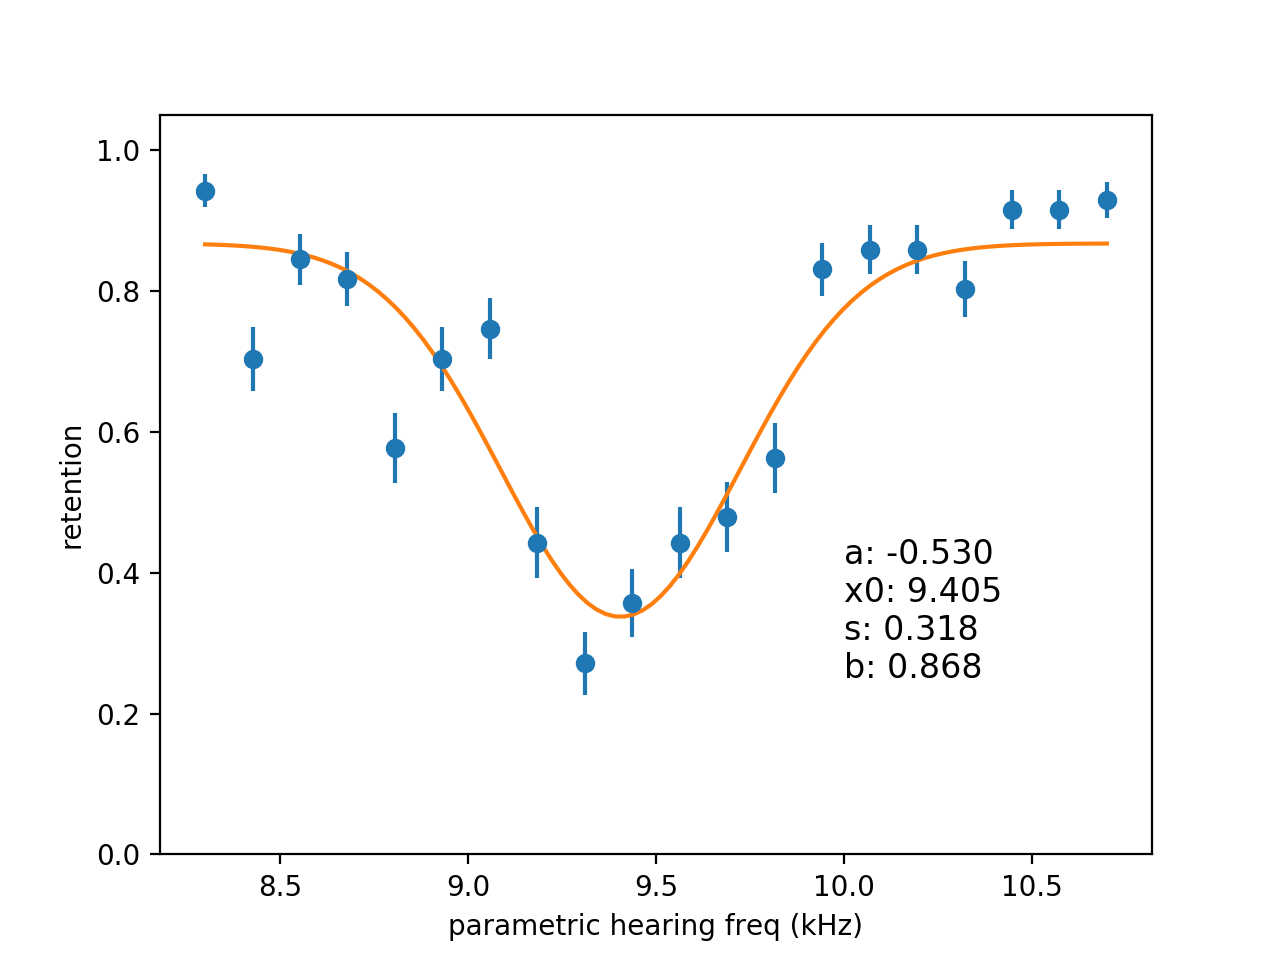

[-0.53028169  9.40497469  0.31837896  0.86781674]


In [55]:
fig, ax = plt.subplots()
for e in range(len(retention['ivar'])):
    ax.errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'o'
    )
ax.set_ylim(0, 1.05)
ax.set_xlabel(xlab)

guess = [-0.5, 10, 1, 1]
for e in range(len(retention['ivar'])):
    popt, pcov = optimize.curve_fit(gaussian, retention['ivar'][e], retention['retention'][e], p0=guess)
    xs = np.linspace(min(retention['ivar'][e]),max(retention['ivar'][e]),100)
    ax.plot(xs, gaussian(xs, *popt))
    fit_data = "a: {:.3f}\nx0: {:.3f}\ns: {:.3f}\nb: {:.3f}"
    ax.text(10, 0.25, fit_data.format(*popt), fontsize=12)

ax.set_ylabel('retention')
print(popt)
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'gaussian_retention_fit.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)